<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/main/Resunet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, concatenate

def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def get_model(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

from keras import backend as K

# Focal Tversky_loss
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

def get_loss_function(loss_function_name):
    if loss_function_name == "focal_tversky_loss":
        loss_function = focal_tversky_loss
    elif loss_function_name == "dice_coef_loss":
        loss_function = dice_coef_loss
    elif loss_function_name == "dice_coef_binary_loss":
        loss_function = dice_coef_binary_loss
    elif loss_function_name == "focal_loss":
        loss_function = focal_loss
    elif loss_function_name == "sparse_categorical_crossentropy":
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    else:
        loss_function = loss_function_name # for keras implemented losses like "categorical_crossentropy"

    return loss_function

2023-12-01 22:12:05.194952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 22:12:05.194974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 22:12:05.194996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 22:12:05.200266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/is/.local/lib/python3.10/site-packages/scipy

In [2]:
INPUT_FEATURES = ['elevation', 'wind_speed', 'wind_dir', 'tmin', 'tmax',
                  'landcover', 'precip', 'pdsi','solar', 'PrevFireMask']

In [3]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
# import model_satunet
import glob
import os
import sys


# Get loss function
loss_function = get_loss_function('dice_coef_loss')

# Define model architecture
model = get_model([64,64,10])

# Callbacks
#!pip install wandb
#import wandb
#from wandb.keras import WandbCallback

callbacks = list()

# Optional: WandB callback config and init
config = {
    "dataset_id": "NDFP_data",
    "img_size": [64,64],
    "model_architecture": 'resunet',
    "num_layers_satunet": 4,
    "unfreeze_all_layers": False,
    "parent_model_name": None,
    "optimizer": 'adam',
    "learning_rate": 0.0001,
    "loss_function": 'dice_coef_loss',
    "epochs": 100,
    "batch_size": 100,
    "custom_objects": [
        "dice_coef",
        "focal_tversky_loss"
        ],
    "input_features": INPUT_FEATURES
    }
#wandb.init(project='fire-model', config=config)
#run_name = wandb.run.name
#callbacks.append(WandbCallback())

# Define learning rate schedule callback
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=15, decay_rate=0.96, staircase=True
    )

#Define checkpoints callback
#checkpoint_path = os.path.join('./output', 'model', 'fire_model_{}.h5'.format(run_name))
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#    checkpoint_path, save_weights_only=True, save_best_only=True
#    )
#callbacks.append(checkpoint_cb)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2023-12-01 22:12:06.983604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 22:12:06.987402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 22:12:06.987516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#from google.colab import drive
#drive.mount('drive')

In [5]:
man_length = 21550

MinMax = {'landcover':(10.0, 100.0),
              'tmax': (-41.95404185202824, 35.28747487720835),
              'tmin': (-42.4077221254351, 34.710974191122716),
              'wind_speed': (0.0002993076576944125, 14.27423496286687),
              'elevation': (-77.85292, 4379.4683),
              'wind_direction': (-179.99999083334689, 179.99999810000588),
              'solar_radiation': (-24.598765964771623, 964662.1183104622),
              'air_pressure': (99064.73425290409, 105551.80433948596),
              'precipitation': (-9.494998975299606e-05, 0.012117456275976952)}

In [6]:
import csv
import gzip
import numpy as np

In [7]:
def normalize(arr, min_value, max_value):
  arr = np.array(arr)
  return (arr - min_value) / (max_value - min_value)

In [8]:
def _float_feature(value):
    """Returns a float_list from a list of float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [9]:
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
tfrecord_file = 'data2.tfrecords'

In [10]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tensor, [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    #tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tensor, [64, 64])
    

    return combined_features, label


In [11]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [12]:
count_records(tfrecord_file)

21550

In [13]:
dataset = tf.data.TFRecordDataset(tfrecord_file).cache()

dataset = dataset.map(_parse_function)


In [14]:
from tqdm import tqdm 
def list_record_features(tfrecords_path):
    # Dict of extracted feature information
    features = {}
    # Iterate records
    #dataset = tf.data.Dataset.list_files(tfrecords_path)
    for rec in tqdm(tf.data.TFRecordDataset([str(tfrecords_path)])):
        # Get record bytes
        example_bytes = rec.numpy()
        # Parse example protobuf message

        keys_to_features = {
            'feature1': tf.io.VarLenFeature(tf.float32),
            'feature2': tf.io.VarLenFeature(tf.float32),
            'feature3': tf.io.VarLenFeature(tf.float32),
            'feature4': tf.io.VarLenFeature(tf.float32),
            'feature5': tf.io.VarLenFeature(tf.float32),
            'feature6': tf.io.VarLenFeature(tf.float32),
            'feature7': tf.io.VarLenFeature(tf.float32),
            'feature8': tf.io.VarLenFeature(tf.float32),
            'feature9': tf.io.VarLenFeature(tf.float32),
            'feature10': tf.io.VarLenFeature(tf.float32),
            'label': tf.io.VarLenFeature(tf.float32)
        }
    
        # Load one example
        parsed_features = tf.io.parse_single_example(example_bytes, keys_to_features)
        
        feature_list = []
        #try:
        for i in range(1, 11):
            shp = tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))
            if shp != [4096]:
                feature = tf.zeros([64, 64])
                print(f"feature {i}, shape : {shp}")
            else:
                feature = tf.reshape(tf.sparse.to_dense(parsed_features[f'feature{i}']), [64, 64])
            feature_list.append(feature)
        #except:
        #    pass
    
        combined_features = tf.stack(feature_list, axis=-1)
        label = tf.zeros([64, 64], tf.float32)
        #try:
        shp = tf.shape(tf.sparse.to_dense(parsed_features[f'label']))
        if shp != [4096]:
            print(f"feature {i}, shape : {shp}")
        else:
            label = tf.reshape(tf.sparse.to_dense(parsed_features['label']), [64, 64])
        #except:
        #    pass

    return combined_features, label

#list_record_features('data.tfrecords')

In [15]:
# for inputs, labels in dataset:
#     print(inputs.shape)

In [16]:
cnt = 0
for inputs, labels in tqdm(dataset):
    cnt += 1
print(cnt)

21550it [00:04, 5225.08it/s]

21550


In [17]:
dataset = dataset.shuffle(buffer_size=man_length)

In [18]:
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

In [19]:
cnt = 0
for inputs, labels in tqdm(train_dataset):
    cnt += 1
print(cnt)

17240it [00:03, 4383.17it/s]

17240


In [20]:
cnt = 0
for inputs, labels in tqdm(test_dataset):
    cnt += 1
print(cnt)

2155it [00:01, 1106.14it/s]

2155


In [21]:
cnt = 0
for inputs, labels in tqdm(eval_dataset):
    cnt += 1
print(cnt)

2155it [00:01, 1114.21it/s]

2155


In [22]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Trainset analysis

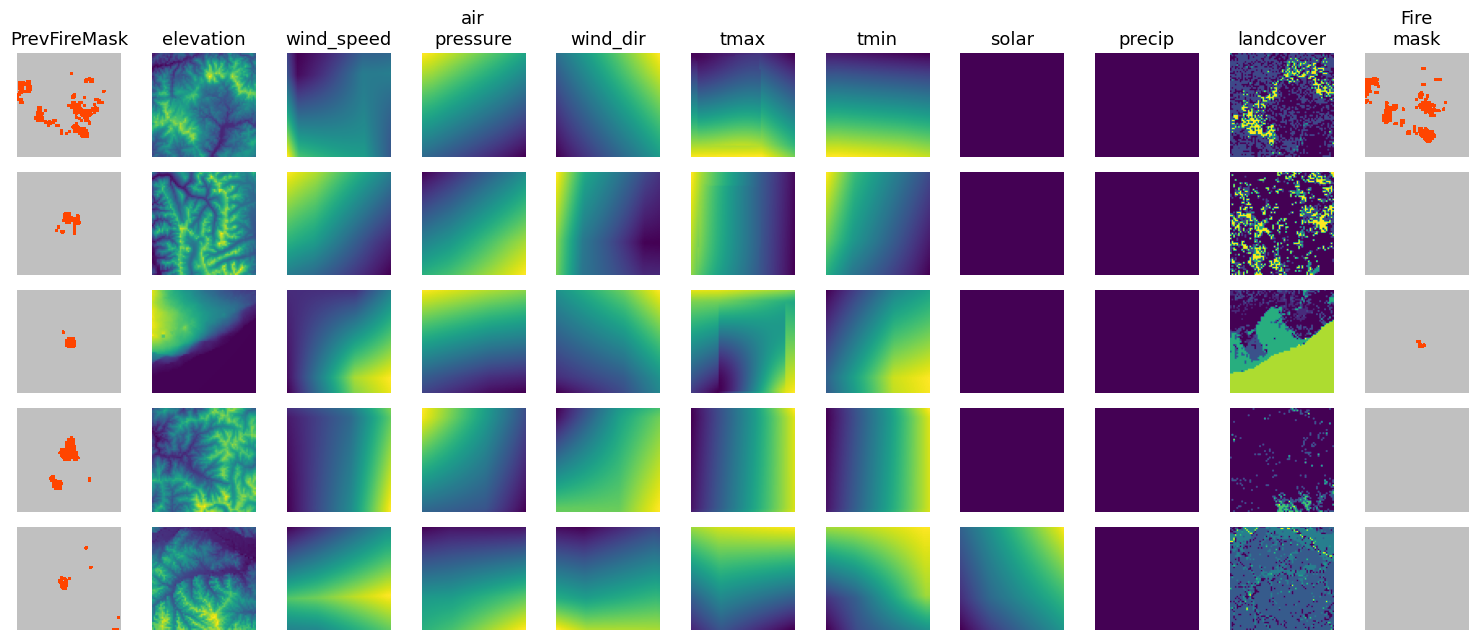

In [23]:
inputs, labels = next(iter(train_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# len(eval_dataset.take(1))

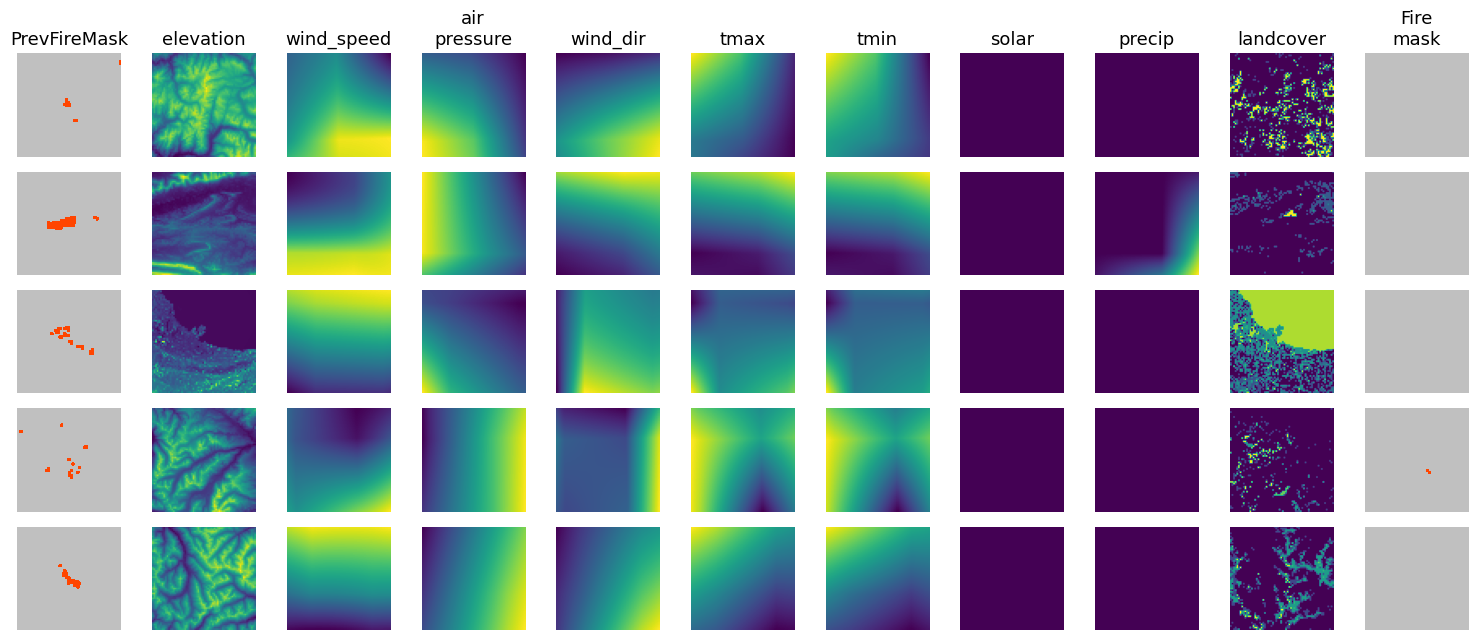

In [25]:
eval_dataset = eval_dataset.shuffle(1000)
inputs, labels = next(iter(eval_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

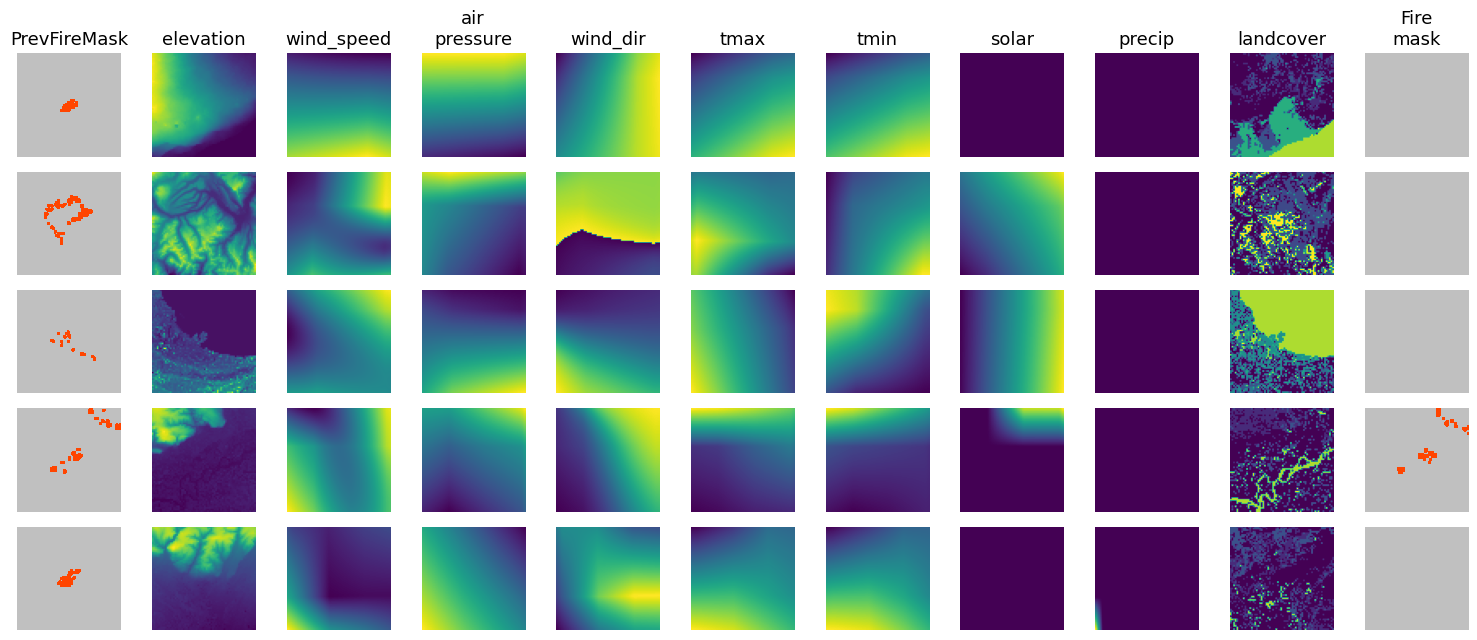

In [26]:
inputs, labels = next(iter(test_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Get all samples from TFRecords in arrays
first_it = True
cnt = 0
for x, y in test_dataset:
    cnt += 1
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
print(f"test inputs num batches = {cnt}")
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)
print(f"test_data_targets.shape {test_data_targets.shape}")
print(f"test_data_inputs.shape {test_data_inputs.shape}")

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, 0].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_true_flat = y_true.flatten()

test inputs num batches = 68
test_data_targets.shape (2155, 64, 64)
test_data_inputs.shape (2155, 64, 64, 10)


In [28]:
# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)

Accuracy: 0.983354
score_a (array([0.99619481, 0.15200828]), array([0.98702224, 0.38158805]), array([0.99158731, 0.21740983]), array([8773393,   53487]))
precision 0.9833535745359628
Recall: 0.983354
F1 score: 0.983354
[[8659534  113859]
 [  33077   20410]]


# Training

In [29]:
# Compile and train model
model.compile(
    optimizer=optimizer,
    loss=loss_function, metrics=[dice_coef,
                                 tf.keras.metrics.AUC(curve="PR"),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()
                                ]
    )

#model.fit(train_dataset, epochs=5)
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


2023-12-01 22:12:56.804596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-01 22:12:56.898475: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 22:12:58.381241: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f453b5dda80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 22:12:58.381260: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-01 22:12:58.384566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 22:12:58.436182: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 [==============================] - 39s 46ms/step - loss: 0.7995 - dice_coef: 0.2006 - auc: 0.0663 - precision: 0.0663 - recall: 0.4328 - val_loss: 0.7570 - val_dice_coef: 0.2427 - val_auc: 0.1117 - val_precision: 0.2183 - val_recall: 0.3182
Epoch 2/100
539/539 [==============================] - 24s 43ms/step - loss: 0.7551 - dice_coef: 0.2449 - auc: 0.1085 - precision: 0.1954 - recall: 0.3596 - val_loss: 0.7408 - val_dice_coef: 0.2592 - val_auc: 0.1198 - val_precision: 0.2192 - val_recall: 0.3532
Epoch 3/100
539/539 [==============================] - 25s 44ms/step - loss: 0.7544 - dice_coef: 0.2456 - auc: 0.1088 - precision: 0.1968 - recall: 0.3620 - val_loss: 0.7674 - val_dice_coef: 0.2333 - val_auc: 0.1013 - val_precision: 0.2025 - val_recall: 0.3174
Epoch 4/100
539/539 [==============================] - 25s 44ms/step - loss: 0.7502 - dice_coef: 0.2498 - auc: 0.1118 - precision: 0.2013 - recall: 0.3650 - val_loss: 0.7614 - val_dice_coef: 0.2379 - val_auc: 0.1020 - val_precisi

# Evaluation

In [30]:
# Predict
y_pred=list()
for sample in tqdm(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    # print("\niter\n")
    # #print(f"sample_exp.shape: {sample_exp.shape}")
    # #im = sample_exp[0, :, :, -1]
    # #print(f"im.shape: {im.shape}")
    # plt.imshow(sample_exp[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    pred = model.predict(sample_exp, verbose = 0)
    
    # #print(f"pred.shape: {pred.shape}")
    # plt.imshow(pred[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2155/2155 [01:12<00:00, 29.69it/s]


Accuracy: 0.986947
score_a (array([0.99611334, 0.19403192]), array([0.99073357, 0.36592069]), array([0.99341618, 0.25359394]), array([8773393,   53487]))
precision 0.9869474831424014
Recall: 0.986947
F1 score: 0.986947
[[8692095   81298]
 [  33915   19572]]


In [31]:
np.where(y_true_flat < 1.)

(array([      0,       1,       2, ..., 8826877, 8826878, 8826879]),)

In [32]:
y_true.shape

(2155, 64, 64)

In [33]:
tf.unique(persistence_mask_flat)

Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(8826880,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

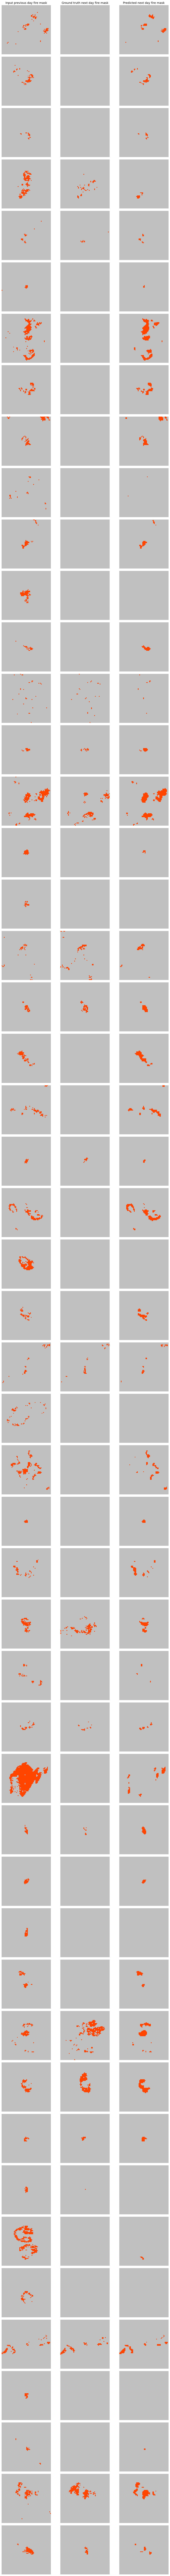

In [34]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [35]:
# f1 score

satunet_mean = np.mean([0.990430, 0.988026, 0.986947])
satunet_std = np.std([0.990430, 0.988026, 0.986947])

print(f"f1 baseline: satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# precision

satunet_mean = np.mean([0.9904296875, 0.9880262335049304, 0.9869474831424014])
satunet_std = np.std([0.9904296875, 0.9880262335049304, 0.9869474831424014])

print(f"precision satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# recall

satunet_mean = np.mean([0.990430, 0.988026, 0.986947])
satunet_std = np.std([0.990430, 0.988026, 0.986947])

print(f"recall satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# accuracy

satunet_mean = np.mean([0.990430,  0.988026, 0.986947])
satunet_std = np.std([0.990430,  0.988026, 0.986947])

print(f"accuracy satunet: {satunet_mean:.5f}+={satunet_std:.5f}")

f1 baseline: satunet: 0.98847+=0.00146
precision satunet: 0.98847+=0.00146
recall satunet: 0.98847+=0.00146
accuracy satunet: 0.98847+=0.00146
